In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import restoration
from tqdm import tqdm
import tifffile
import torch

def plot_fourier(fourier):
    plt.imshow(np.log(1+np.abs(fourier)))

def circular_filter(array_shape, pixel_radius):
    filter = np.zeros(array_shape)
    N = array_shape[0]
    x, y = np.arange(N), np.arange(N)
    X, Y = np.meshgrid(x, y)
    filter[(X-N//2)**2 + (Y-N//2)**2 < pixel_radius**2] = 1
    return filter

def get_maxindex(array):
    coords = np.where(array==array.max())
    row = coords[0][0]
    column = coords[1][0]
    return [row, column]

def get_maxindex_3d(array_3d):
    coords = np.where(array_3d==array_3d.max())
    row = coords[0][0]
    column = coords[1][0]
    z = coords[2][0]
    return [row, column, z]

def phiShift(restored_p2, n=1):
    imY, imX = restored_p2.shape
    bsize = 8

    mask = np.ones((imY, imX))
    mask[bsize:imY-bsize, bsize:imX-bsize] = 0

    imY, imX = restored_p2.shape
    XX, YY = np.meshgrid(np.arange(imX), np.arange(imY))
    p2mask = restored_p2 * mask
    
    # Omit Outliers
    list_ = p2mask[p2mask != 0].flatten()
    p25 = np.percentile(list_, 25)
    p75 = np.percentile(list_, 75)
    cmin = p25 - 1.5 * (p75 - p25)
    cmax = p75 + 1.5 * (p75 - p25)
    p2mask[p2mask < cmin] = 0
    p2mask[p2mask > cmax] = 0
    
    # Find Coeffitients(?)
    p2mask = p2mask.flatten()
    X = np.zeros((len(p2mask[p2mask!=0]), n))
    Y = np.zeros((len(p2mask[p2mask!=0]), n))
    for ii in range(n):
        XXX = (XX**1).flatten()
        YYY = (YY**1).flatten()
        XXX = XXX[p2mask!=0]
        YYY = YYY[p2mask!=0]
        X[:, ii] = XXX
        Y[:, ii] = YYY
        
    p2mask = p2mask[p2mask!=0]
    E = np.ones(len(p2mask))
    AA = np.column_stack((X, Y, E))
    coefficients = np.linalg.lstsq(AA, p2mask, rcond=None)[0]
    
    goodp2 = restored_p2 - coefficients[-1] * np.ones((imY, imX))
    for ii in range(n):
        goodp2 -= coefficients[ii] * XX**(ii+1)
        goodp2 -= coefficients[n + ii] * YY**(ii+1)
    
    return goodp2

In [3]:
import napari

viewer = napari.Viewer()

<h1> 1. Field retrieval from hologram </h1>

In [83]:
background = tifffile.imread('SiO2_1_bg.tif')
sample = tifffile.imread('SiO2_1_sp.tif')

N = background[0].shape[0]
Z = background.shape[0]
cutoff = 1/3

In [84]:
m = 1
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

NA = 1.2
lam = 532 * nm
v_optical = NA/lam * um
# dx = 0.1*um # dx=lam/(4*NA)=110nm=0.11um # here NA=1.2
dx = 0.1
Dx = N * dx
dv = 1/Dx

height = 70
dv_z = 1/(height*dx)

<h3> object_center gives frequency coordinate of illumination beam in fourier space </h3>

\begin{gather*}


I(\vec{r}) = |R+U|^2 \\
\hat{I(\vec{\nu})} = \mathcal{F} [I(\vec{r})]\\
\mathcal{P} [\hat{I(\vec{\nu})}] = center[cut[\hat{I(\vec{\nu})}]]= center [\mathcal{F} [R^* U]] = \mathcal{F} [U] \\
\Downarrow \\
U(\vec{r}) = \mathcal{F}^{-1} [\mathcal{F} [U]] 


\end{gather*}

<h3> find holographic reference center </h3>

In [85]:
ref_fourier = np.fft.fftshift(np.fft.fft2(background[0]))
ref_fourier[:, int(N*cutoff):-1] = 0
reference_center = get_maxindex(ref_fourier)
shifts = N//2 - np.array(reference_center)
reference_center, shifts

([55, 56], array([145, 144], dtype=int64))

<h3> Reference Beam Centering</h3>

In [87]:
cutoff = 400
new_start_idx = (N-cutoff)//2
new_end_idx = (N+cutoff)//2

new_size = new_end_idx - new_start_idx
background_fourier = np.zeros((Z, new_size, new_size), dtype=np.complex64)
sample_fourier = np.zeros((Z, new_size, new_size), dtype=np.complex64)
filter = circular_filter((new_size, new_size), pixel_radius=100)

for i in tqdm(range(Z)):
    back_temp = np.fft.fftshift(np.fft.fft2(background[i]))
    sample_temp = np.fft.fftshift(np.fft.fft2(sample[i]))
    
    back_temp = np.roll(back_temp, shift=shifts[0], axis=0)
    back_temp = np.roll(back_temp, shift=shifts[1], axis=1)
    back_temp = back_temp * filter
    
    sample_temp = np.roll(sample_temp, shift=shifts[0], axis=0)
    sample_temp = np.roll(sample_temp, shift=shifts[1], axis=1)
    sample_temp = sample_temp * filter
    
    background_fourier[i] = back_temp[new_start_idx:new_end_idx, new_start_idx:new_end_idx]
    sample_fourier[i] = sample_temp[new_start_idx:new_end_idx, new_start_idx:new_end_idx]


100%|██████████| 40/40 [00:00<00:00, 86.69it/s]


<h3> find illumination peak from background fourier </h3>

\begin{gather*}

U(\vec{r}) \equiv A e^{i \phi} \\
\Downarrow \\
A = |\frac{U_s}{U_b}|\\
\phi = \angle \frac{U_s}{U_b}

\end{gather*}

In [89]:
N = new_size

retrieved_background = np.zeros((40, N, N), dtype=np.complex64)
retrieved_field = np.zeros((40, N, N), dtype=np.complex64)
angles = np.zeros((40, N, N))

for i in tqdm(range(40)):
    back_temp = np.fft.ifft2(background_fourier[i])
    sample_temp = np.fft.ifft2(sample_fourier[i])
    
    # background
    retrieved_background[i] = np.abs(back_temp) * np.exp(1j*np.angle(back_temp))
    
    # sample
    sample_angle = restoration.unwrap_phase(np.angle(sample_temp/back_temp))
    sample_angle = phiShift(sample_angle)
    sample_amplitude = np.abs(sample_temp/back_temp)
    angles[i] = sample_angle

    retrieved_field[i] = sample_amplitude * np.exp(1j * sample_angle)

100%|██████████| 40/40 [00:02<00:00, 17.37it/s]


<h1> 2. Applying the Fourier diffraction Theorem </h3>

In [90]:
phase = np.zeros((Z, N, N))
amplitude = np.zeros((Z, N, N))

for i in range(Z):
    phase[i] = restoration.unwrap_phase(np.angle(retrieved_field[i]))
    amplitude[i] = np.abs(retrieved_field[i])

In [91]:
f_dx = np.zeros(Z)
f_dy = np.zeros(Z)
mj_0 = 0
mi_0 = 0

for i in range(Z):
    F_back = np.fft.fft2(retrieved_background[i])
    # find illumination center
    m = get_maxindex(F_back)
    # normal illumination
    if i==0:
        mi_0 = m[0]
        mj_0 = m[1]
    
    # obliqueness
    f_dx[i] = mj_0-m[1]
    f_dy[i] = mi_0-m[0]

In [92]:
n_medium = 1.33
k0_nm = (1/lam) * n_medium * um

k0_x = dv * np.array(f_dx)
k0_y = dv * np.array(f_dy)
k0_z = np.real(np.sqrt(k0_nm**2 - k0_x**2 - k0_y**2))

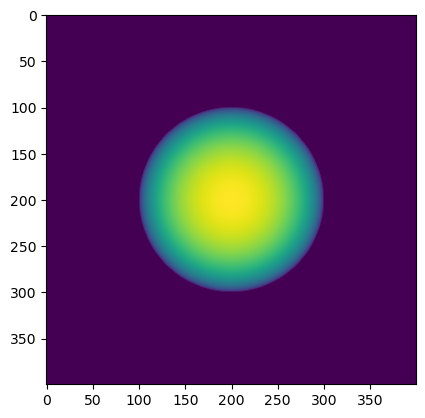

In [93]:
fourier_x = np.arange(-N//2, N//2) * dv
fourier_y = np.arange(-N//2, N//2) * dv
fourier_z = np.arange(-height//2, height//2) * dv

Fourier_X, Fourier_Y = np.meshgrid(fourier_x, fourier_y)
Fourier_Z = np.sqrt(Fourier_X**2 + Fourier_Y**2)

fourier_y = fourier_y[:, None]

k3 = k0_nm**2 - Fourier_Z**2
k3[k3<0] = 0
k3 = np.sqrt(k3)
plt.imshow(k3)

In [94]:
mask = Fourier_Z.copy()
mask[mask > 2*NA/lam*um] = 0
mask = mask.astype(bool)

rytov = np.zeros((N, N, height))
count = np.zeros((N, N, height))

In [95]:
filter = circular_filter((N, N), pixel_radius=v_optical//dv)

for i in tqdm(range(Z)):
    F_rytov = np.log(amplitude[i]) + 1j*phase[i]
    Us_rytov = np.fft.fftshift(np.fft.fft2(F_rytov)) * dx * dx
    Us_rytov = np.roll(Us_rytov, int(k0_y[i]/dv), axis=0)
    Us_rytov = np.roll(Us_rytov, int(k0_x[i]/dv), axis=1)
    Us_rytov = Us_rytov * filter
        
    size_check = np.zeros((N, N))
    kz = k3 + size_check
    kx = fourier_x + size_check
    ky = fourier_y + size_check
        
    Kx = kx - k0_x[i]
    Ky = ky - k0_y[i]
    Kz = kz - k0_z[i]
        
    Uprime = (kz/1j) * Us_rytov

    xind = np.where(
            ((kz > 0) * filter.astype(bool)) &
            (Kx > (dv * (-np.floor(N / 2)))) &
            (Ky > (dv * (-np.floor(N / 2)))) &
            (Kz > (dv_z * (-np.floor(height / 2)))) &
            (Kx < (dv * (np.floor(N / 2) - 1))) &
            (Ky < (dv * (np.floor(N / 2) - 1))) &
            (Kz < (dv_z * (np.floor(height / 2) - 1)))
        )
    xind = np.ravel_multi_index((xind[0], xind[1]), Uprime.shape)

    # 이 밑에가 ewald sphere 만드는부분
    Uprime = Uprime.flat[xind]
    Kx = Kx.flat[xind]
    Ky = Ky.flat[xind]
    Kz = Kz.flat[xind]

    Kx = np.round(Kx / dv + np.floor(N / 2) + 1).astype(int)
    Ky = np.round(Ky / dv + np.floor(N / 2) + 1).astype(int)
    Kz = np.round(Kz / dv_z + np.floor(height / 2) + 1).astype(int)

    Kzp = np.ravel_multi_index((Ky, Kx, Kz), count.shape)
        
    temp = rytov.flat[Kzp]
    rytov.flat[Kzp] = temp + Uprime
    count.flat[Kzp] += (Uprime != 0)

# Final computation and normalization
rytov[count > 0] = rytov[count > 0] / count[count > 0] / np.prod(np.array([dv, dv, dv_z]))

  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\김민욱\AppData\Local\Temp\ipykernel_13612\1855206978.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  rytov.flat[Kzp] = temp + Uprime
100%|██████████| 40/40 [00:00<00:00, 74.18it/s]


In [96]:
rytov = np.fft.ifftn(rytov)
potential = rytov * 4 * np.pi
k0 = 1/lam
k = 2 * np.pi * n_medium * k0
ri = n_medium * np.sqrt(1+potential/k**2)

viewer.add_image(np.real(ri))

<Image layer 'Image [1]' at 0x28fcaedcb90>

\begin{gather*}

\lambda = 532 nm \\
\nu_{optical} = \frac{NA}{\lambda} \\
\delta x \equiv \frac{\lambda}{NA} = 110nm \sim 100nm = 0.1 \mu m \\
\Delta x = N * \delta x \\
\delta \nu = \frac{1}{\Delta x}

\end{gather*}

\begin{gather*}
x \in \delta x * (-\frac{N}{2}, +\frac{N}{2}) \\
y \in \delta y * (-\frac{N}{2}, +\frac{N}{2}) \\

\\

\nu_x \in \delta \nu_x * (-\frac{N}{2}, +\frac{N}{2}) \\
\nu_y \in \delta \nu_y * (-\frac{N}{2}, +\frac{N}{2}) \\
\nu_z \equiv \sqrt{\nu^2 - \nu_x^2 - \nu_y^2}
\end{gather*}

1. Fourier diffraction theorem 

$$
\hat{U}^{(s)}_{1B}(\vec{k}) = - \frac{1}{i \lambda s_z} \hat{F}(\vec{K})
$$

2. To get a scattered 1st Born approximation field, we first need to calculate an illumination beam at object lens plane
$$
U^{(i)}(x,y;0) = e^{i k \vec{s_0} \cdot \vec{r}}|_{z=0} = e^{i 2 \pi (\nu _{0x} x + \nu _{0y} y)}
$$

3. Then straightforwardly,
$$
U = U^{(i)} + U^{(s)} \Rightarrow U^{(s)} = U - U^{(i)}